# Chicago Divvy Bicycle Sharing Data

#### Link Kaggle
https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

#### Descrição das features:
<br><b>trip_idID</b> attached to each trip taken
<br><b>year</b>
<br><b>month</b>
<br><b>week</b> week No.
<br><b>day</b> 
<br><b>hour</b> 
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

### Bibliotecas

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, BatchNormalization, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks
import tensorflow as tf


#warnings.filterwarnings('ignore')

### Carregar dataset

In [3]:
#Carregar dataset
path = "data.csv"
df = pd.read_csv(path)

df.shape

(9495235, 23)

### Correções

In [4]:
#Corringindo campo day com 0
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

### Novas Features

In [5]:
#Campo data
df['date'] = df.starttime.astype(str).str[:13]  + ':00:00'

#Convertendo para datetime
df.date = pd.to_datetime(df.date)

### Consolidando dados

In [6]:
#Agregação por date
df2 =  df.groupby(['date']).size().reset_index(name='count')

#Date como index
df2.index = df2['date']
del df2['date']

df2.head(5)
df2.tail(5)

,count
date,
2017-12-31 17:00:00,38
2017-12-31 18:00:00,27
2017-12-31 20:00:00,19
2017-12-31 22:00:00,9
2017-12-31 23:00:00,7


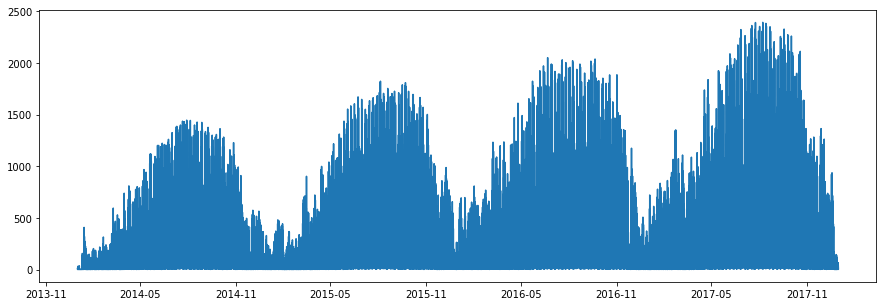

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(df2)
plt.show()

### Normalizando features

In [8]:
values = df2['count'].values.reshape(-1,1)
values = values.astype('float32')
f_norm = MinMaxScaler(feature_range=(0, 1))
v_norm = f_norm.fit_transform(values)

### Particionando Sets

In [9]:
#Definindo o tamanho de cada set
train_size = int(len(v_norm) * 0.8)
test_size  = (5*24)
val_size   = len(v_norm) - train_size - test_size

#Particionando os sets
train = v_norm[0:train_size,:]
val   = v_norm[train_size:(train_size+val_size),:]
test  = v_norm[(train_size+val_size):len(v_norm),:]

#Volume de dados
print('Train:', len(train))
print('Val:  ', len(val))
print('Test: ', len(test))

Train: 27693
Val:   6804
Test:  120


### Definindo Modelo

In [10]:
batch_size=2
time_steps=24

trainGenerator = TimeseriesGenerator(train, train,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
valGenerator = TimeseriesGenerator(val,  val,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
testGenerator = TimeseriesGenerator(test,  test,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

#Reshape
#trainX_ = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#valX_   = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

#Dfinindo modelo LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, train.shape[1])))

#model.add(Dropout(0.25))
#model.add(Dense(128))
#model.add(BatchNormalization())

model.add(Dense(1))

print(model.summary())

#Compilando Modelo
model.compile(loss='mean_squared_error', optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


### Treinando Modelo

In [13]:
epochs = 1000
batch_size = 300

fit = True

if fit: 
    #Fit nos dados
    history = model.fit_generator(trainGenerator, 
                        steps_per_epoch= 30, 
                        epochs = epochs,
                        validation_data = valGenerator,
                        callbacks=[
                            callbacks.EarlyStopping(patience=100),
                            callbacks.ModelCheckpoint('best.3.h5', save_best_only=True, save_weights_only=True, verbose=1)
                        ])
else:
    model.load_weights('best.3.h5')

Epoch 1/1000
30/30 [==============================] - 16s 543ms/step - loss: 0.0165 - val_loss: 0.0263

Epoch 00001: val_loss improved from inf to 0.02631, saving model to best.3.h5
Epoch 2/1000
30/30 [==============================] - 15s 507ms/step - loss: 0.0124 - val_loss: 0.0261

Epoch 00002: val_loss improved from 0.02631 to 0.02608, saving model to best.3.h5
Epoch 3/1000
30/30 [==============================] - 17s 561ms/step - loss: 0.0173 - val_loss: 0.0210

Epoch 00003: val_loss improved from 0.02608 to 0.02099, saving model to best.3.h5
Epoch 4/1000
30/30 [==============================] - 16s 532ms/step - loss: 0.0144 - val_loss: 0.0220

Epoch 00004: val_loss did not improve from 0.02099
Epoch 5/1000
30/30 [==============================] - 15s 511ms/step - loss: 0.0044 - val_loss: 0.0205

Epoch 00005: val_loss improved from 0.02099 to 0.02054, saving model to best.3.h5
Epoch 6/1000
30/30 [==============================] - 17s 569ms/step - loss: 0.0064 - val_loss: 0.0209

E

30/30 [==============================] - 14s 466ms/step - loss: 0.0056 - val_loss: 0.0079

Epoch 00049: val_loss did not improve from 0.00778
Epoch 50/1000
30/30 [==============================] - 14s 480ms/step - loss: 0.0045 - val_loss: 0.0085

Epoch 00050: val_loss did not improve from 0.00778
Epoch 51/1000
30/30 [==============================] - 14s 462ms/step - loss: 0.0027 - val_loss: 0.0078

Epoch 00051: val_loss improved from 0.00778 to 0.00777, saving model to best.3.h5
Epoch 52/1000
30/30 [==============================] - 14s 464ms/step - loss: 0.0057 - val_loss: 0.0076

Epoch 00052: val_loss improved from 0.00777 to 0.00755, saving model to best.3.h5
Epoch 53/1000
30/30 [==============================] - 14s 470ms/step - loss: 0.0051 - val_loss: 0.0084

Epoch 00053: val_loss did not improve from 0.00755
Epoch 54/1000
30/30 [==============================] - 14s 464ms/step - loss: 0.0028 - val_loss: 0.0072

Epoch 00054: val_loss improved from 0.00755 to 0.00717, saving mode


Epoch 00098: val_loss did not improve from 0.00493
Epoch 99/1000
30/30 [==============================] - 14s 458ms/step - loss: 0.0028 - val_loss: 0.0048

Epoch 00099: val_loss improved from 0.00493 to 0.00484, saving model to best.3.h5
Epoch 100/1000
30/30 [==============================] - 14s 459ms/step - loss: 0.0051 - val_loss: 0.0047

Epoch 00100: val_loss improved from 0.00484 to 0.00466, saving model to best.3.h5
Epoch 101/1000
30/30 [==============================] - 14s 469ms/step - loss: 0.0036 - val_loss: 0.0124

Epoch 00101: val_loss did not improve from 0.00466
Epoch 102/1000
30/30 [==============================] - 14s 463ms/step - loss: 0.0044 - val_loss: 0.0058

Epoch 00102: val_loss did not improve from 0.00466
Epoch 103/1000
30/30 [==============================] - 14s 468ms/step - loss: 0.0031 - val_loss: 0.0054

Epoch 00103: val_loss did not improve from 0.00466
Epoch 104/1000
30/30 [==============================] - 14s 468ms/step - loss: 0.0031 - val_loss: 0.00

30/30 [==============================] - 20s 653ms/step - loss: 0.0016 - val_loss: 0.0039

Epoch 00149: val_loss did not improve from 0.00355
Epoch 150/1000
30/30 [==============================] - 20s 655ms/step - loss: 0.0035 - val_loss: 0.0052

Epoch 00150: val_loss did not improve from 0.00355
Epoch 151/1000
30/30 [==============================] - 19s 650ms/step - loss: 0.0030 - val_loss: 0.0047

Epoch 00151: val_loss did not improve from 0.00355
Epoch 152/1000
30/30 [==============================] - 19s 644ms/step - loss: 0.0019 - val_loss: 0.0049

Epoch 00152: val_loss did not improve from 0.00355
Epoch 153/1000
30/30 [==============================] - 20s 653ms/step - loss: 0.0052 - val_loss: 0.0048

Epoch 00153: val_loss did not improve from 0.00355
Epoch 154/1000
30/30 [==============================] - 20s 652ms/step - loss: 0.0022 - val_loss: 0.0042

Epoch 00154: val_loss did not improve from 0.00355
Epoch 155/1000
30/30 [==============================] - 19s 650ms/step - 

30/30 [==============================] - 20s 681ms/step - loss: 9.9054e-04 - val_loss: 0.0032

Epoch 00200: val_loss improved from 0.00321 to 0.00315, saving model to best.3.h5
Epoch 201/1000
30/30 [==============================] - 20s 659ms/step - loss: 0.0028 - val_loss: 0.0034

Epoch 00201: val_loss did not improve from 0.00315
Epoch 202/1000
30/30 [==============================] - 19s 645ms/step - loss: 0.0013 - val_loss: 0.0040

Epoch 00202: val_loss did not improve from 0.00315
Epoch 203/1000
30/30 [==============================] - 20s 654ms/step - loss: 8.2192e-04 - val_loss: 0.0039

Epoch 00203: val_loss did not improve from 0.00315
Epoch 204/1000
30/30 [==============================] - 19s 630ms/step - loss: 0.0018 - val_loss: 0.0035

Epoch 00204: val_loss did not improve from 0.00315
Epoch 205/1000
30/30 [==============================] - 20s 673ms/step - loss: 0.0013 - val_loss: 0.0032

Epoch 00205: val_loss did not improve from 0.00315
Epoch 206/1000
30/30 [============


Epoch 00250: val_loss did not improve from 0.00220
Epoch 251/1000
30/30 [==============================] - 20s 658ms/step - loss: 4.8467e-04 - val_loss: 0.0025

Epoch 00251: val_loss did not improve from 0.00220
Epoch 252/1000
30/30 [==============================] - 20s 671ms/step - loss: 0.0015 - val_loss: 0.0026

Epoch 00252: val_loss did not improve from 0.00220
Epoch 253/1000
30/30 [==============================] - 22s 727ms/step - loss: 0.0015 - val_loss: 0.0029

Epoch 00253: val_loss did not improve from 0.00220
Epoch 254/1000
30/30 [==============================] - 21s 690ms/step - loss: 0.0029 - val_loss: 0.0038

Epoch 00254: val_loss did not improve from 0.00220
Epoch 255/1000
30/30 [==============================] - 20s 674ms/step - loss: 9.4519e-04 - val_loss: 0.0035

Epoch 00255: val_loss did not improve from 0.00220
Epoch 256/1000
30/30 [==============================] - 21s 690ms/step - loss: 0.0027 - val_loss: 0.0035

Epoch 00256: val_loss did not improve from 0.0022

30/30 [==============================] - 20s 669ms/step - loss: 6.7432e-04 - val_loss: 0.0026

Epoch 00302: val_loss did not improve from 0.00190
Epoch 303/1000
30/30 [==============================] - 20s 668ms/step - loss: 0.0021 - val_loss: 0.0026

Epoch 00303: val_loss did not improve from 0.00190
Epoch 304/1000
30/30 [==============================] - 20s 665ms/step - loss: 0.0019 - val_loss: 0.0038

Epoch 00304: val_loss did not improve from 0.00190
Epoch 305/1000
30/30 [==============================] - 20s 654ms/step - loss: 6.1185e-04 - val_loss: 0.0041

Epoch 00305: val_loss did not improve from 0.00190
Epoch 306/1000
30/30 [==============================] - 20s 677ms/step - loss: 0.0018 - val_loss: 0.0027

Epoch 00306: val_loss did not improve from 0.00190
Epoch 307/1000
30/30 [==============================] - 20s 671ms/step - loss: 9.6371e-04 - val_loss: 0.0025

Epoch 00307: val_loss did not improve from 0.00190
Epoch 308/1000
30/30 [==============================] - 20s 6

30/30 [==============================] - 20s 675ms/step - loss: 9.2276e-04 - val_loss: 0.0028

Epoch 00354: val_loss did not improve from 0.00190
Epoch 355/1000
30/30 [==============================] - 20s 663ms/step - loss: 0.0012 - val_loss: 0.0026

Epoch 00355: val_loss did not improve from 0.00190
Epoch 356/1000
30/30 [==============================] - 20s 666ms/step - loss: 5.7827e-04 - val_loss: 0.0023

Epoch 00356: val_loss did not improve from 0.00190
Epoch 357/1000
30/30 [==============================] - 20s 674ms/step - loss: 5.8994e-04 - val_loss: 0.0025

Epoch 00357: val_loss did not improve from 0.00190
Epoch 358/1000
30/30 [==============================] - 20s 655ms/step - loss: 0.0021 - val_loss: 0.0027

Epoch 00358: val_loss did not improve from 0.00190
Epoch 359/1000
30/30 [==============================] - 19s 649ms/step - loss: 0.0019 - val_loss: 0.0024

Epoch 00359: val_loss did not improve from 0.00190
Epoch 360/1000
30/30 [==============================] - 20s 6

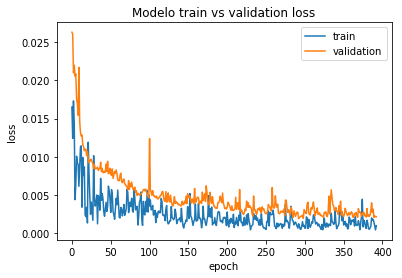

In [14]:
#Plotando
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Predict

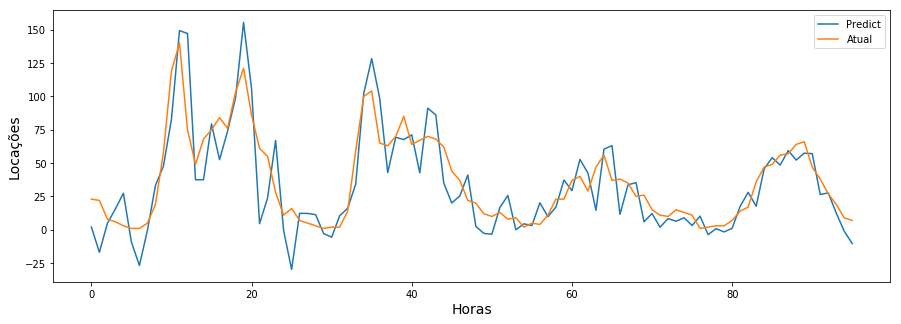

In [15]:
#Reshape test
#testX_ = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Predict
mpred = model.predict_generator(testGenerator)

#Convertendo para valor não normalizado
mpred_inverse = f_norm.inverse_transform(mpred.reshape(-1, 1))
testY_inverse = f_norm.inverse_transform(test.reshape(-1, 1))

#Eixo X do gráfico como data
#predictDates = df2.tail(len(mpred_inverse)).index

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(mpred_inverse, label='Predict')
plt.plot(testY_inverse[time_steps:,], label='Atual')
plt.xlabel('Horas', fontsize=14)
plt.ylabel('Locações', fontsize=14)
plt.legend()
plt.show()

### Previsão a longo prazo

<p>Informaremos 24 horas do set de teste para o modelo, e suas saidas serão incluidas novamente no modelo para tentarmos prever a longo prazo.
<img src="prevlp_1.png">

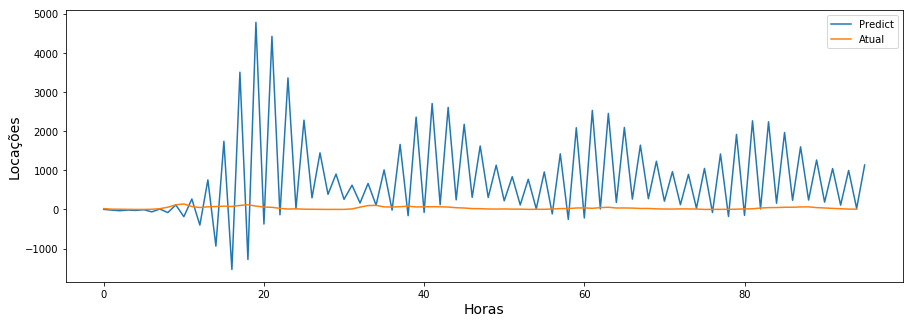

In [16]:
#Quantidade de itens para o set inicial (número de horas: 24)
batch_size=1
time_steps=24

#Inicialização vetor que armazenará as 24 iniciais 
predX = []

#N itens do set de test (time_steps)
predX = test[:(time_steps+batch_size)]
np.array(predX)

#Loop para alimentar o predict
for i in range(len(test)-time_steps):
    #Criando generator sempre com as ultimas 25 horas do array
    testGenerator_ = TimeseriesGenerator(predX[-(time_steps+batch_size):,],  predX[-(time_steps+batch_size):,],
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
    #Predict das ultimas 25 horas
    mpred_lp = model.predict_generator(testGenerator_)
    #Concatenação da hora prevista(1 saida apenas)
    predX = np.append(predX, [mpred_lp])
    predX = np.reshape(predX, (predX.shape[0], 1))
    

#Removendo as 24 horas iniciais do set de teste    
predX = predX[time_steps+batch_size:]

#Convertendo para valor não normalizado
predX_inverse = f_norm.inverse_transform(predX.reshape(-1, 1))

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predX_inverse, label='Predict')
plt.plot(testY_inverse[time_steps+batch_size:,], label='Atual')
plt.xlabel('Horas', fontsize=14)
plt.ylabel('Locações', fontsize=14)
plt.legend()
plt.show()

### Consideramos que o modelo consegue prever até 6 horas com precisão

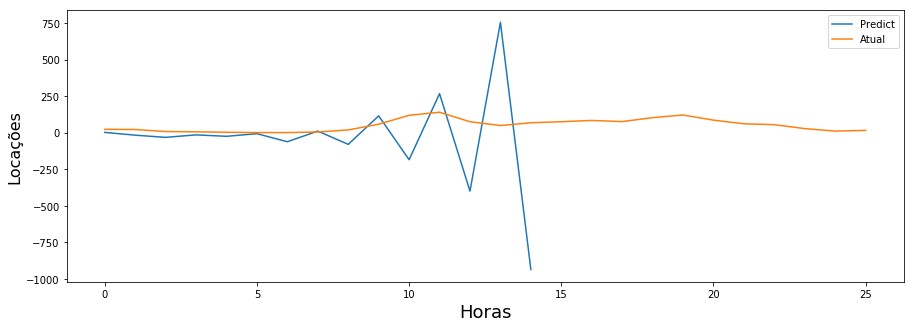

In [17]:
#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predX_inverse[:15], label='Predict')
plt.plot(testY_inverse[time_steps:50,], label='Atual')
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Locações', fontsize=16)
plt.legend()
plt.show()